In [ ]:
# default_exp classification.data.common

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Classification Common
> Basic image/data opening/processing/loading functionality

In [ ]:
# export
import logging
from typing import *

import albumentations as A
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2
from fastcore.all import *
from PIL import Image
from timm.data.constants import *
from timm.data.transforms import ToNumpy

from gale.core.classes import Configurable

_logging = logging.getLogger(__name__)

<IPython.core.display.Javascript object>

In [ ]:
from fastcore.test import *

from gale.core.utils.logger import setup_logger
from gale.core.utils.visualize import show_image, show_images

_IMAGE = "images/puppy.jpg"

setup_logger()
_logger = logging.getLogger("gale.classification.data.transforms")

<IPython.core.display.Javascript object>

## Helper Functions

In [ ]:
# export
def pil_loader(path: str) -> Image.Image:
    """
    Loads in a Image using PIL
    """
    im = Image.open(path).convert("RGB")
    return im

<IPython.core.display.Javascript object>

PIL library loads an Image from a path and returns the Image in `PIL.Image.Image` format ...

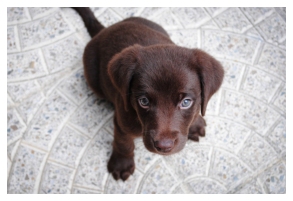

<IPython.core.display.Javascript object>

In [ ]:
im = pil_loader(_IMAGE)
show_image(im)

assert isinstance(im, Image.Image)

In [ ]:
# export
def cv2_loader(path: str) -> np.ndarray:
    """
    Loads in a Image using cv2
    """
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

<IPython.core.display.Javascript object>

Contrary to PIL, `cv2` loads and returns the Image in `np.ndarray` ...

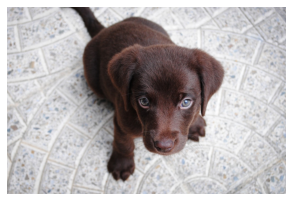

<IPython.core.display.Javascript object>

In [ ]:
im = cv2_loader(_IMAGE)
show_image(im)

assert isinstance(im, np.ndarray)

In [ ]:
# export
@typedispatch
def convert_image(image: Image.Image):
    return np.array(image)

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def convert_image(image: np.ndarray):
    return Image.fromarray(image)

<IPython.core.display.Javascript object>

## Apply Transform methods -

In [ ]:
# export
@typedispatch
def load_and_apply_image_transforms(path: str, transforms: A.Compose):
    image = cv2_loader(path)
    aug_image = transforms(image=image)
    return aug_image["image"]

<IPython.core.display.Javascript object>

<AxesSubplot:>

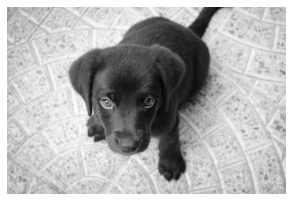

<IPython.core.display.Javascript object>

In [ ]:
albu_augs = A.Compose([A.HorizontalFlip(p=1.0), A.ToGray(p=1.0)])
image = load_and_apply_image_transforms(_IMAGE, albu_augs)
show_image(image)

In [ ]:
# export
@typedispatch
def load_and_apply_image_transforms(path: str, transforms: T.Compose):
    image = pil_loader(path)
    aug_image = transforms(image)
    return aug_image

<IPython.core.display.Javascript object>

<AxesSubplot:>

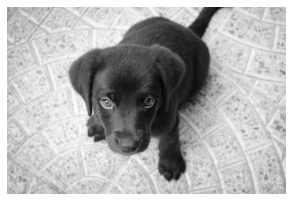

<IPython.core.display.Javascript object>

In [ ]:
tv_augs = T.Compose([T.RandomHorizontalFlip(p=1.0), T.Grayscale(num_output_channels=3)])
image = load_and_apply_image_transforms(_IMAGE, tv_augs)
show_image(image)

In [ ]:
# export
@typedispatch
def load_and_apply_image_transforms(path: str, transforms: None):
    return pil_loader(path)

<IPython.core.display.Javascript object>

<AxesSubplot:>

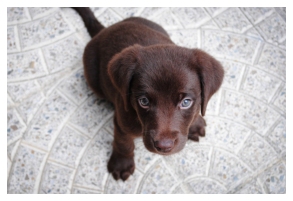

<IPython.core.display.Javascript object>

In [ ]:
image = load_and_apply_image_transforms(_IMAGE, None)
show_image(image)

## DatasetMapper-

In [ ]:
# export
class ClassificationMapper(DisplayedTransform):
    decodes = noop
    """
    A callable which takes in a dataset and map it into a format used by the model.
    This mapper takes in a Dict/str as input . The key "file_name" must contain the
    path to the Image to be loaded and key "target" must contain the integer target.

    The callable currently does the following:
    1. Reads in the image from `file_name`.
    2. Applies transformations to the Images
    3. Converts dataset to return `torch.Tensor` Images & `torch.long` targets
    
    You can also optionally pass in `xtras` these which must be a callable functions. This function
    is applied after converting the images to to tensors. Helpfull for applying trasnformations like
    RandomErasing which requires the inputs to be tensors.
    """

    def __init__(
        self,
        augmentations: Optional[Union[T.Compose, A.Compose]] = None,
        mean: Sequence[float] = IMAGENET_DEFAULT_MEAN,
        std: Sequence[float] = IMAGENET_DEFAULT_STD,
        xtras: Optional[Callable] = noop,
    ):
        """
        Arguments:
        1. `augmentations`: a list of augmentations or deterministic transforms to apply
        2. `mean`, `std`: list or tuple with #channels element, representing the per-channel mean and
        std to be used to normalize the input image. Note: These should be normalized values.
        4. `xtras`: A callabcle funtions applied after images are normalized and converted to tensors.
        """
        store_attr()
        self.np_conversion = ToNumpy()

        # fmt: off
        self.normalize = T.Compose([
            T.ToTensor(),
            T.Normalize(torch.tensor(self.mean), torch.tensor(self.std)),
        ])
        # fmt: on

    def encodes(self, dataset_dict: Dict):
        """
        Arguments:
        1. dataset_dict: A Dictionary containing the "file_name" and "target"

        Returns : Tuple containing `images (torch.Tensor)` and `targets (torch.FloatTensor)`.
        Note - that the Images are returned in CHW format
        """
        # fmt: off
        image = load_and_apply_image_transforms(dataset_dict["file_name"], self.augmentations)
        # fmt: on
        image = self.normalize(image)
        image = self.xtras(image)

        assert isinstance(image, torch.Tensor)

        target = dataset_dict["target"]
        target = torch.tensor(target, dtype=torch.long)
        return image, target

    def encodes(self, image_path: str):
        """
        Arguments:
        1. image_path: a str contraining the path of the Images

        Returns: `images (torch.Tensor)`. Note - that the Images are returned in CHW format
        """
        image = load_and_apply_image_transforms(image_path, self.augmentations)
        image = self.normalize(image)
        image = self.xtras(image)

        assert isinstance(image, torch.Tensor)
        return image

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationMapper.__init__)

<h4 id="ClassificationMapper.__init__" class="doc_header"><code>ClassificationMapper.__init__</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationMapper.__init__</code>(**`augmentations`**:`Union`\[`Compose`, `Compose`, `NoneType`\]=*`None`*, **`mean`**:`Sequence`\[`float`\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Sequence`\[`float`\]=*`(0.229, 0.224, 0.225)`*, **`xtras`**:`Optional`\[`Callable`\]=*`noop`*)

Arguments:
1. `augmentations`: a list of augmentations or deterministic transforms to apply
2. `mean`, `std`: list or tuple with #channels element, representing the per-channel mean and
std to be used to normalize the input image. Note: These should be normalized values.
4. `xtras`: A callabcle funtions applied after images are normalized and converted to tensors.

<IPython.core.display.Javascript object>

In [ ]:
augs = [
    A.Rotate(p=1.0),
    A.Cutout(num_holes=1, max_h_size=15, max_w_size=15, p=1.0),
    A.HueSaturationValue(p=1.0),
]
augs = A.Compose(augs)

mapper = ClassificationMapper(augmentations=augs)

<IPython.core.display.Javascript object>

In [ ]:
mapper

ClassificationMapper -- {'augmentations': Compose([
  Rotate(always_apply=False, p=1.0, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None),
  Cutout(always_apply=False, p=1.0, num_holes=1, max_h_size=15, max_w_size=15),
  HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}), 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'xtras': <function noop at 0x7fad377770d0>}:
encodes: (Dict,object) -> encodes
(str,object) -> encodes
decodes: (object,object) -> noop

<IPython.core.display.Javascript object>

For training datasets `ClassificationMapper` takes in a `OrderedDict` or `Dict` which contains the keys `file_name`, `targets`; these corresponds to the file path of the Image and the Interger target label for the Image ...

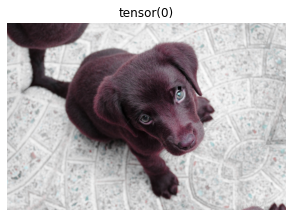

<IPython.core.display.Javascript object>

In [ ]:
dataset_dict = OrderedDict(file_name=_IMAGE, target=0)
im, targ = mapper(dataset_dict)

# de-normalize image
im = im.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([im], titles=[targ], imsize=5)

For test datasets `ClassificationMapper` takes in a `str` which corresponds to the file path of the Image.

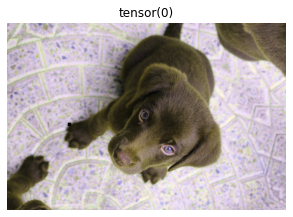

<IPython.core.display.Javascript object>

In [ ]:
im = mapper(_IMAGE)

# de-normalize image
im = im.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([im], titles=[targ], imsize=5)

> Note: For Image Classification all your augmentations must return `uint8 or PIL images`. Normalization and conversion to tensors are handled independently by the library.

## Export-

In [ ]:
# hide
notebook2script()